# Model Selection and Validation

As with Bayesian inference, model selection and validation are fundamental steps in statistical learning applications. In particular, we wish to select the model that performs optimally, both with respect to the training data and to external data. 

Depending on the type of learning method we use, we may be interested in one or more of the following:

* how many variables should be included in the model?
* what hyperparameter values should be used in fitting the model?
* how many groups should we use to cluster our data?


[Givens and Hoeting (2012)](#references) includes a dataset for salmon spawning success. If we plot the number of recruits against the number of spawners, we see a distinct positive relationship, as we would expect. 

The question is, *what sort of polynomial relationship best describes the relationship?*

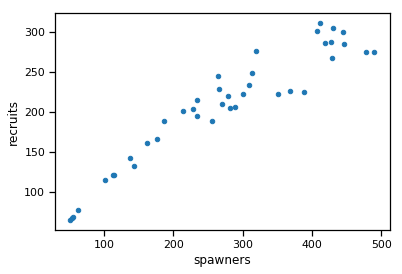

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
import warnings
warnings.simplefilter("ignore")

salmon = pd.read_table("../data/salmon.txt", sep=r'\s+', index_col=0)
salmon.plot(x='spawners', y='recruits', kind='scatter');

On the one extreme, a linear relationship is underfit; on the other, we see that including a very large number of polynomial terms is clearly overfitting the data.

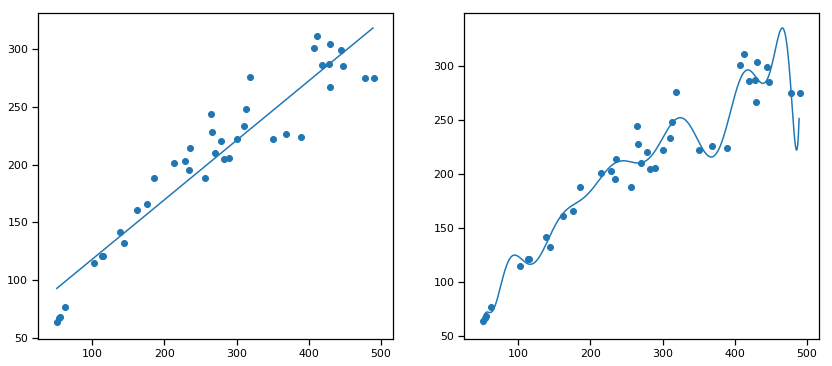

In [2]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

xvals = np.arange(salmon.spawners.min(), salmon.spawners.max())

fit1 = np.polyfit(salmon.spawners, salmon.recruits, 1)
p1 = np.poly1d(fit1)
axes[0].plot(xvals, p1(xvals))
axes[0].scatter(x=salmon.spawners, y=salmon.recruits)

fit15 = np.polyfit(salmon.spawners, salmon.recruits, 15)
p15 = np.poly1d(fit15)
axes[1].plot(xvals, p15(xvals))
axes[1].scatter(x=salmon.spawners, y=salmon.recruits)

We can select an appropriate polynomial order for the model using **cross-validation**, in which we hold out a testing subset from our dataset, fit the model to the remaining data, and evaluate its performance on the held-out subset.

In [3]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(salmon.spawners, 
                            salmon.recruits, test_size=0.3, random_state=42)

A natural criterion to evaluate model performance is root mean square error.

In [4]:
def rmse(x, y, coefs):
    yfit = np.polyval(coefs, x)
    return np.sqrt(np.mean((y - yfit) ** 2))

We can now evaluate the model at varying polynomial degrees, and compare their fit.

Text(0,0.5,'rms error')

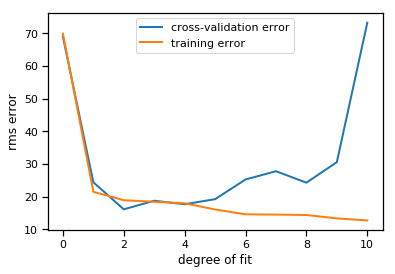

In [5]:
degrees = np.arange(11)

# preallocate training and validation error vectors
train_err = np.zeros(len(degrees))
validation_err = np.zeros(len(degrees))

for i, d in enumerate(degrees):
    p = np.polyfit(xtrain, ytrain, d)

    train_err[i] = rmse(xtrain, ytrain, p)
    validation_err[i] = rmse(xtest, ytest, p)

fig, ax = plt.subplots()

ax.plot(degrees, validation_err, lw=2, label = 'cross-validation error')
ax.plot(degrees, train_err, lw=2, label = 'training error')

ax.legend(loc=0)
ax.set_xlabel('degree of fit')
ax.set_ylabel('rms error')

In the cross-validation above, notice that the error is high for both very low and very high polynomial values, while training error declines monotonically with degree. The cross-validation error is composed of two components: **bias** and **variance**. When a model is overfit, bias is low but variance is high, while when a model is underfit, the reverse is true.

One can show that the MSE decomposes into a sum of the bias (squared) and variance of the estimator:

$$\begin{aligned}
\text{Var}(\hat{\theta}) &= E[\hat{\theta} - \theta]^2 - (E[\hat{\theta} - \theta])^2 \\
\Rightarrow E[\hat{\theta} - \theta]^2 &= \text{Var}(\hat{\theta}) + \text{Bias}(\hat{\theta})^2
\end{aligned}$$

The training error, on the other hand, does not have this tradeoff; it will always decrease (or at least, never increase) as variables (polynomial terms) are added to the model.

### Information-theoretic Model Selection

One approach to model selection is to use an information-theoretic criterion to identify the most appropriate model. Akaike (1973) found a formal relationship between Kullback-Leibler information (a dominant paradigm in information and coding theory) and likelihood theory. Akaike's Information Criterion (AIC) is an estimator of expected relative K-L information based on the maximized log-likelihood function, corrected for asymptotic bias. 

$$\text{AIC} = −2 \log(L(\theta|data)) + 2K$$

AIC balances the fit of the model (in terms of the likelihood) with the number of parameters required to achieve that fit. We can easily calculate AIC from the residual sums of squares as:

$$\text{AIC} = n \log(\text{RSS}/n) + 2k$$

where $k$ is the number of parameters in the model. Notice that as the number of parameters increase, the residual sum of squares goes down, but the second term (a penalty) increases.

To apply AIC to a model selection problem, we choose the model that has the lowest AIC value.

[AIC can be shown to be equivalent to leave-one-out cross-validation](http://www.jstor.org/stable/2984877).

In [6]:
aic = lambda rss, n, k: n*np.log(float(rss)/n) + 2*k

We can use AIC to select the appropriate polynomial degree.

In [7]:
p, residuals, rank, singular_values, rcond = np.polyfit(
                                salmon.spawners, salmon.recruits, 3, full=True)

Text(0,0.5,'AIC')

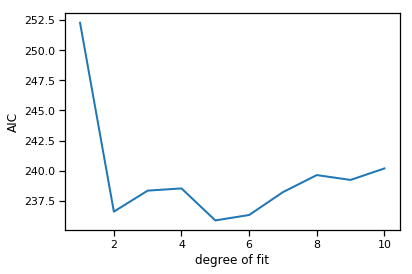

In [8]:
aic_values = np.zeros(len(degrees))
params = np.zeros((len(degrees), len(degrees)))

for i, d in enumerate(degrees):
    p, residuals, rank, singular_values, rcond = np.polyfit(
                                salmon.spawners, salmon.recruits, d, full=True)
    aic_values[i] = aic((residuals).sum(), len(salmon.spawners), d+1)
    params[i, :(d+1)] = p

plt.plot(degrees[1:], aic_values[1:], lw=2)
plt.xlabel('degree of fit')
plt.ylabel('AIC')

For ease of interpretation, AIC values can be transformed into model weights via:

$$w_i = \frac{\exp(-\frac{1}{2} \delta \text{AIC}_i)}{\sum_{m=1}^M \exp(-\frac{1}{2} \delta \text{AIC}_m)}$$

In [9]:
aic_trans = np.exp(-0.5*aic_values)
aic_probs = aic_trans/aic_trans.sum()
aic_probs.round(2)

array([0.  , 0.  , 0.18, 0.08, 0.07, 0.26, 0.21, 0.08, 0.04, 0.05, 0.03])

For some problems, we can use AIC weights to perform multimodel inference, whereby we use model weights to calculate model-averaged parameter estimates, thereby accounting for model selection uncertainty.

As an example, consider the body fat dataset that is used in Chapter 12 of Givens and Hoeting (2012). It measures the percentage of body fat for 251 men, estimated using an underwater weighing technique.  In addition, the variables age, weight, height, and ten body circumference measurements were recorded for each subject.

In [10]:
bodyfat = pd.read_table("../data/bodyfat.dat", sep='\s+')
bodyfat.head()

,fat,age,weight,height,neck,chest,abd,hip,thigh,knee,ankle,biceps,forearm,wrist
0,12.6,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.9,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,24.6,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.9,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,27.8,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


To illustrate model selection, we will consider 5 competing models consisting of different subsets of available covariates.

In [11]:
np.random.seed(1)
subsets = [np.random.choice(bodyfat.columns[1:], np.random.randint(2, 12), replace=False) for i in range(5)]
subsets

[array(['neck', 'thigh', 'hip', 'height', 'biceps', 'chest', 'weight'],
       dtype=object),
 array(['knee', 'neck', 'wrist', 'ankle', 'age', 'hip'], dtype=object),
 array(['wrist', 'neck', 'height', 'forearm', 'abd', 'knee', 'biceps',
        'chest', 'age', 'weight', 'ankle'], dtype=object),
 array(['biceps', 'height', 'ankle', 'wrist', 'age', 'chest', 'forearm',
        'knee', 'weight', 'abd'], dtype=object),
 array(['forearm', 'thigh', 'knee', 'hip', 'abd', 'biceps'], dtype=object)]

We can use scikit-learn to estimate an ordinary least squares (OLS) model for a given set of predictors.

In [12]:
from sklearn.linear_model import LinearRegression

fit = LinearRegression().fit(y=bodyfat['fat'], X=bodyfat[subsets[3]])

In [13]:
fit.coef_

array([ 0.20437007, -0.02583531,  0.21069249, -1.76900335,  0.03867909,
       -0.02872919,  0.4072649 ,  0.10976073, -0.12891889,  0.89101484])

Using the model output, we can extract the residual sums of squares and use this to calculate AIC.

In [14]:
ss = ((fit.predict(bodyfat[subsets[3]]) - bodyfat['fat'])**2).sum()

In [15]:
n, k = bodyfat[subsets[3]].shape
aic(ss, n=n, k=k)

708.1597678369503

We can calculate the AIC value for each model:

Text(0,0.5,'AIC')

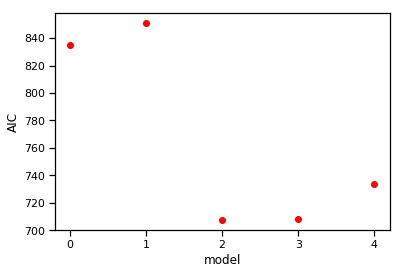

In [16]:
aic_values = np.zeros(len(subsets))
params = pd.DataFrame(np.zeros((len(subsets), bodyfat.shape[1]-1)), columns=bodyfat.columns[1:])

for i, s in enumerate(subsets):
    x = bodyfat[s]
    y = bodyfat['fat']
    fit = LinearRegression().fit(y=y, X=x)
    ss = ((fit.predict(x) - y)**2).sum()
    n, k = x.shape
    aic_values[i] = aic(ss, n=n, k=k)
    params.loc[i, s] = fit.coef_

plt.plot(aic_values, 'ro')
plt.xlabel('model')
plt.gca().set_xticks(np.arange(5))
plt.ylabel('AIC')

And we can extract the parameters of the best model:

In [17]:
params.round(2)

,age,weight,height,neck,chest,abd,hip,thigh,knee,ankle,biceps,forearm,wrist
0,0.00,0.06,-0.79,-0.51,0.51,0.00,0.15,0.10,0.00,0.00,-0.11,0.00,0.00
1,0.23,0.00,0.00,0.38,0.00,0.00,0.79,0.00,0.05,-0.02,0.00,0.00,-2.40
2,0.04,-0.10,-0.06,-0.37,-0.03,0.88,0.00,0.00,0.06,0.17,0.23,0.45,-1.53
3,0.04,-0.13,-0.03,0.00,-0.03,0.89,0.00,0.00,0.11,0.21,0.20,0.41,-1.77
4,0.00,0.00,0.00,0.00,0.00,0.84,-0.46,0.22,-0.34,0.00,-0.11,0.04,0.00


In [18]:
p_best = params.loc[np.where(aic_values==aic_values.min())]
p_best.round(2)

,age,weight,height,neck,chest,abd,hip,thigh,knee,ankle,biceps,forearm,wrist
2,0.04,-0.1,-0.06,-0.37,-0.03,0.88,0.0,0.0,0.06,0.17,0.23,0.45,-1.53


For better interpretability, the AIC values for a set of models (conditional on a particular dataset) can be converted to AIC model weights via:

$$p_i = \frac{\exp^{-\frac{1}{2} AIC_i}}{\sum_j \exp^{-\frac{1}{2} AIC_j} }$$

In [19]:
aic_trans = np.exp(-0.5*(aic_values - aic_values.min()))
aic_probs = aic_trans/aic_trans.sum()
aic_probs.round(2)

array([0.  , 0.  , 0.62, 0.38, 0.  ])

The resulting set of model weights can be used to calculate model-averaged parameter values, which are more robust because they account for model selection uncertainty.

In [20]:
p_weighted = ((params.T * aic_probs).T).sum(0)
p_weighted.round(2)

age        0.04
weight    -0.11
height    -0.05
neck      -0.23
chest     -0.03
abd        0.89
hip       -0.00
thigh      0.00
knee       0.08
ankle      0.19
biceps     0.22
forearm    0.43
wrist     -1.62
dtype: float64

## K-fold Cross-validation

In **k-fold cross-validation**, the training set is split into *k* smaller sets. Then, for each of the k "folds":

1. train model on *k-1* of the folds as training data
2. validate this model on the remaining fold, using an appropriate metric

The performance measure reported by k-fold CV is then the average of the *k* computed values. This approach can be computationally expensive, but does not waste too much data, which is an advantage over having a fixed test subset.

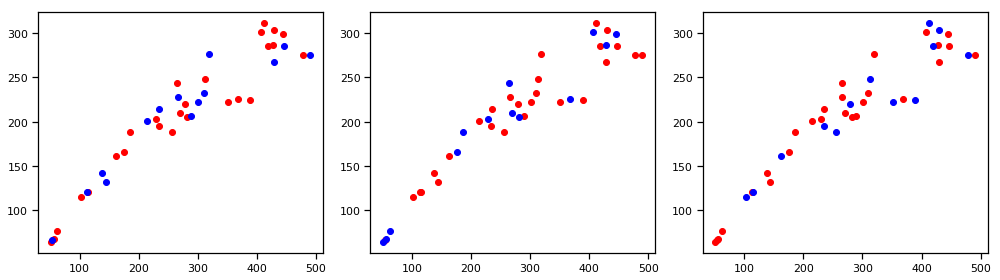

In [21]:
from sklearn.model_selection import cross_val_score, KFold
RNG = np.random.RandomState(42)

nfolds = 3
fig, axes = plt.subplots(1, nfolds, figsize=(14,4))
kf = KFold(n_splits=nfolds, shuffle=True, random_state=RNG)
for i, fold in enumerate(kf.split(salmon.values)):
    training, validation = fold
    y, x = salmon.values[training].T
    axes[i].plot(x, y, 'ro')
    y, x = salmon.values[validation].T
    axes[i].plot(x, y, 'bo')
plt.tight_layout()

Text(0,0.5,'average rms error')

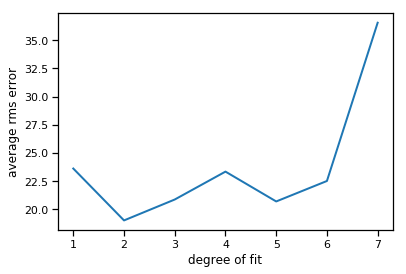

In [22]:
k = 5
degrees = np.arange(1,8)
k_fold_err = np.empty(len(degrees))

for i, d in enumerate(degrees):
    
    error = np.empty(k)
    
    #for j, fold in enumerate(gen_k_folds(salmon, k)):
    for j, fold in enumerate(KFold(n_splits=k, random_state=RNG).split(salmon.values)):

        training, validation = fold
        
        y_train, x_train = salmon.values[training].T
        y_test, x_test = salmon.values[validation].T
        
        p = np.polyfit(x_train, y_train, d)
        
        error[j] = rmse(x_test, y_test, p)

    k_fold_err[i] = error.mean()
        

fig, ax = plt.subplots()

ax.plot(degrees, k_fold_err, lw=2)
ax.set_xlabel('degree of fit')
ax.set_ylabel('average rms error')

If the model shows high **bias**, the following actions might help:

- **Add more features**. In our example of predicting home prices,
  it may be helpful to make use of information such as the neighborhood
  the house is in, the year the house was built, the size of the lot, etc.
  Adding these features to the training and test sets can improve
  a high-bias estimator
- **Use a more sophisticated model**. Adding complexity to the model can
  help improve on bias. For a polynomial fit, this can be accomplished
  by increasing the degree d. Each learning technique has its own
  methods of adding complexity.
- **Decrease regularization**. Regularization is a technique used to impose
  simplicity in some machine learning models, by adding a penalty term that
  depends on the characteristics of the parameters. If a model has high bias,
  decreasing the effect of regularization can lead to better results.
  
If the model shows **high variance**, the following actions might help:

- **Use fewer features**. Using a feature selection technique may be
  useful, and decrease the over-fitting of the estimator.
- **Use a simpler model**.  Model complexity and over-fitting go hand-in-hand.
- **Use more training samples**. Adding training samples can reduce
  the effect of over-fitting, and lead to improvements in a high
  variance estimator.
- **Increase regularization**. Regularization is designed to prevent
  over-fitting. In a high-variance model, increasing regularization
  can lead to better results.

## Bootstrap aggregating regression

Splitting datasets into training, cross-validation and testing subsets is inefficient, particularly when the original dataset is not large. As an alternative, we can use bootstrapping to both develop and validate our model without dividing our dataset. One algorithm to facilitate this is the **bootstrap aggreggation** (or *bagging*) algorithm.

A Bagging regressor is an **ensemble meta-estimator** that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction.

In [23]:
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import PolynomialFeatures

X,y = salmon.values.T
br = BaggingRegressor(LinearRegression(), oob_score=True, random_state=20090425)
X2 = PolynomialFeatures(degree=2).fit_transform(X[:, None])
br.fit(X2, y)

/home/nathan/anaconda3/envs/bios8366/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


BaggingRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=True,
         random_state=20090425, verbose=0, warm_start=False)

In order to evaluate a particular model, the samples that were not selected for a particular resampled dataset (the **out-of-bag** sample) can be used to estimate the generalization error.

In [24]:
br.oob_score_

0.8481969802137755

`scikit-learn` includes a convenient facility called a **pipeline**, whcih can be used to chain two or more estimators into a single function. This is particularly useful in joining a sequence of preprocessing steps with the estimator. You can even perform grid search over all the parameters of the set estimators in the pipeline simultaneously. Note that all estimators in a pipeline, save the last one, must be transformers (*i.e.* must have a transform method). 

We will use it here to join the bagging regressor, polynomial feature selection, and linear regression into a single function.

In [25]:
from sklearn.pipeline import make_pipeline

def polynomial_bagging_regression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree=degree),
                        BaggingRegressor(LinearRegression(), **kwargs))

In [26]:
scores = []

for d in degrees:
    
    print('fitting', d)
    pbr = polynomial_bagging_regression(d, oob_score=True)
    pbr.fit(X[:, None], y)
    scores.append(pbr.score(X[:, None], y))

fitting 1
fitting 2
fitting 3
fitting 4
fitting 5
fitting 6
fitting 7


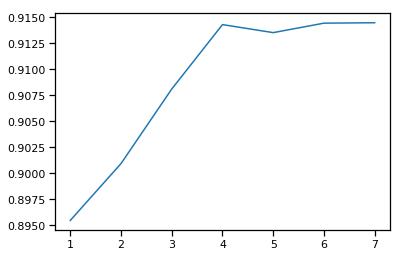

In [27]:
plt.plot(np.arange(1, 8), scores)

## Regularization

The `scikit-learn` package includes a built-in dataset of diabetes progression, taken from [Efron *et al.* (2003)](http://arxiv.org/pdf/math/0406456.pdf), which includes a set of 10 normalized predictors.

In [28]:
from sklearn import datasets

# Predictors: "age" "sex" "bmi" "map" "tc"  "ldl" "hdl" "tch" "ltg" "glu"
diabetes = datasets.load_diabetes()

Let's examine how a linear regression model performs across a range of sample sizes.

In [29]:
diabetes['data'].shape

(442, 10)

In [30]:
from sklearn import model_selection

def plot_learning_curve(estimator, label=None):
    scores = list()
    train_sizes = np.linspace(10, 200, 10).astype(np.int)
    for train_size in train_sizes:
        test_error = model_selection.cross_val_score(estimator, diabetes['data'], diabetes['target'],
                        cv=model_selection.ShuffleSplit(train_size=train_size, 
                                                         test_size=200, 
                                                         random_state=0)
                        )
        scores.append(test_error)

    plt.plot(train_sizes, np.mean(scores, axis=1), label=label or estimator.__class__.__name__)
    plt.ylim(0, 1)
    plt.ylabel('Explained variance on test set')
    plt.xlabel('Training set size')
    plt.legend(loc='best')

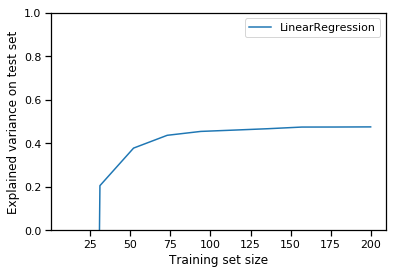

In [31]:
plot_learning_curve(LinearRegression())

Notice the linear regression is not defined for scenarios where the number of features/parameters exceeds the number of observations. It performs poorly as long as the number of sample is not several times the number of features.



One approach for dealing with overfitting is to **regularize** the regression model.

The **ridge estimator** is a simple, computationally efficient regularization for linear regression.

$$\hat{\beta}^{ridge} = \text{argmin}_{\beta}\left\{\sum_{i=1}^N (y_i - \beta_0 - \sum_{j=1}^k x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^k \beta_j^2 \right\}$$

Typically, we are not interested in shrinking the mean, and coefficients are **standardized** to have zero mean and unit L2 norm. Hence,

$$\hat{\beta}^{ridge} = \text{argmin}_{\beta} \sum_{i=1}^N (y_i - \sum_{j=1}^k x_{ij} \beta_j)^2$$

$$\text{subject to } \sum_{j=1}^k \beta_j^2 < \lambda$$

Note that this is *equivalent* to a Bayesian model $y \sim N(X\beta, I)$ with a Gaussian prior on the $\beta_j$:

$$\beta_j \sim \text{N}(0, \lambda)$$

The estimator for the ridge regression model is:

$$\hat{\beta}^{ridge} = (X'X + \lambda I)^{-1}X'y$$

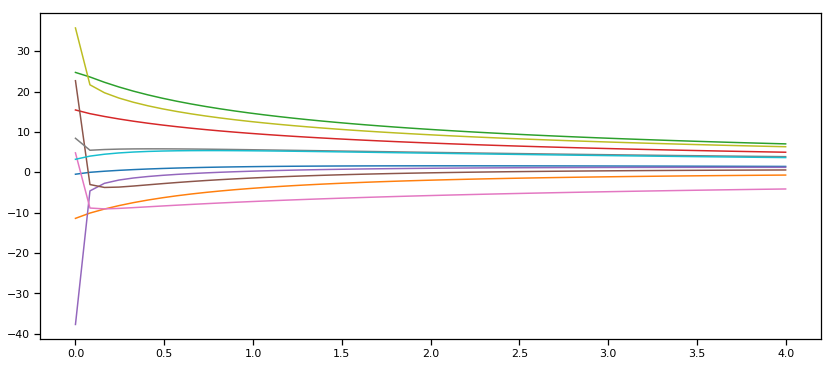

In [32]:
from sklearn import preprocessing
from sklearn.linear_model import Ridge

k = diabetes['data'].shape[1]
alphas = np.linspace(0, 4)
params = np.zeros((len(alphas), k))
for i,a in enumerate(alphas):
    X = preprocessing.scale(diabetes['data'])
    y = diabetes['target']
    fit = Ridge(alpha=a, normalize=True).fit(X, y)
    params[i] = fit.coef_

plt.figure(figsize=(14,6))
for param in params.T:
    plt.plot(alphas, param)

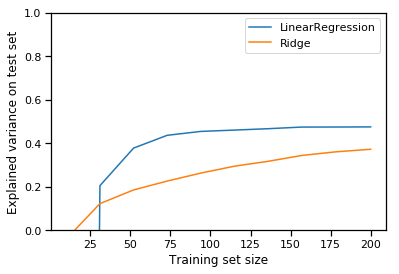

In [33]:
plot_learning_curve(LinearRegression())
plot_learning_curve(Ridge())

Notice that at very small sample sizes, the ridge estimator outperforms the unregularized model.

The regularization of the ridge is a **shrinkage**: the coefficients learned are shrunk towards zero.

The amount of regularization is set via the `alpha` parameter of the ridge, which is tunable. The `RidgeCV` method in `scikits-learn` automatically tunes this parameter via cross-validation.

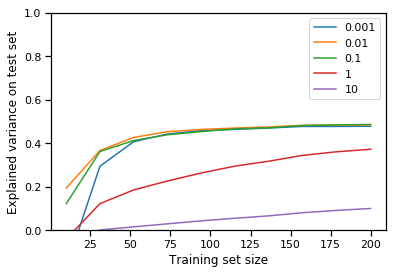

In [34]:
for a in [0.001, 0.01, 0.1, 1, 10]:
    plot_learning_curve(Ridge(a), a)

scikit-learn's `RidgeCV` class automatically tunes the L2 penalty using Generalized Cross-Validation.

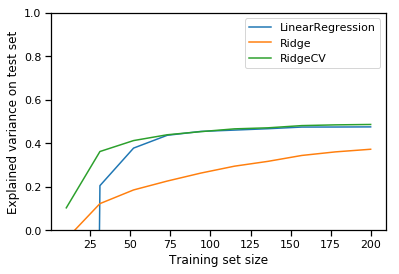

In [35]:
from sklearn.linear_model import RidgeCV

plot_learning_curve(LinearRegression())
plot_learning_curve(Ridge())
plot_learning_curve(RidgeCV())

**The Lasso estimator** is useful to impose sparsity on the coefficients. In other words, it is to be prefered if we believe that many of the features are not relevant.

$$\hat{\beta}^{lasso} = \text{argmin}_{\beta}\left\{\frac{1}{2}\sum_{i=1}^N (y_i - \beta_0 - \sum_{j=1}^k x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^k |\beta_j| \right\}$$

or, similarly:

$$\hat{\beta}^{lasso} = \text{argmin}_{\beta} \frac{1}{2}\sum_{i=1}^N (y_i - \sum_{j=1}^k x_{ij} \beta_j)^2$$
$$\text{subject to } \sum_{j=1}^k |\beta_j| < \lambda$$

Note that this is *equivalent* to a Bayesian model $y \sim N(X\beta, I)$ with a **Laplace** prior on the $\beta_j$:

$$\beta_j \sim \text{Laplace}(\lambda) = \frac{\lambda}{2}\exp(-\lambda|\beta_j|)$$

Note how the Lasso imposes sparseness on the parameter coefficients:

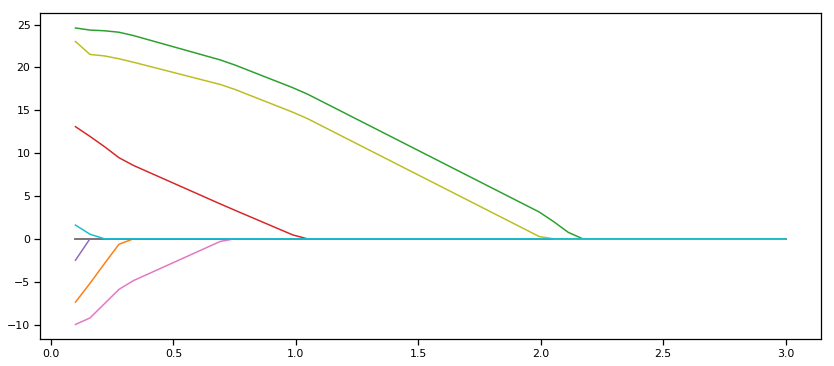

In [36]:
from sklearn.linear_model import Lasso

k = diabetes['data'].shape[1]
alphas = np.linspace(0.1, 3)
params = np.zeros((len(alphas), k))
for i,a in enumerate(alphas):
    X = preprocessing.scale(diabetes['data'])
    y = diabetes['target']
    fit = Lasso(alpha=a, normalize=True).fit(X, y)
    params[i] = fit.coef_

plt.figure(figsize=(14,6))
for param in params.T:
    plt.plot(alphas, param)

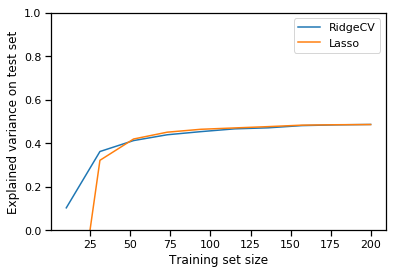

In [37]:
plot_learning_curve(RidgeCV())
plot_learning_curve(Lasso(0.05))

In this example, the ridge estimator performs better than the lasso, but when there are fewer observations, the lasso matches its performance. Otherwise, the variance-reducing effect of the lasso regularization is unhelpful relative to the increase in bias.

With the lasso too, me must tune the regularization parameter for good performance. There is a corresponding `LassoCV` function in `scikit-learn`, but it is computationally expensive. To speed it up, we can reduce the number of values explored for the alpha parameter.

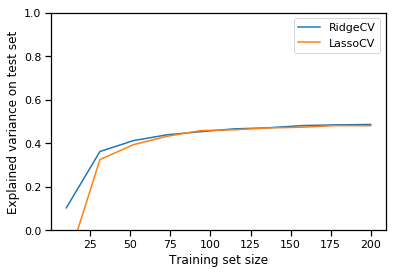

In [38]:
from sklearn.linear_model import LassoCV

plot_learning_curve(RidgeCV())
plot_learning_curve(LassoCV(n_alphas=10, max_iter=5000))

Can't decide? **ElasticNet** is a compromise between lasso and ridge regression.

$$\hat{\beta}^{elastic} = \text{argmin}_{\beta}\left\{\frac{1}{2}\sum_{i=1}^N (y_i - \beta_0 - \sum_{j=1}^k x_{ij} \beta_j)^2 + (1 - \alpha) \sum_{j=1}^k \beta^2_j + \alpha \sum_{j=1}^k |\beta_j| \right\}$$

where $\alpha = \lambda_1/(\lambda_1 + \lambda_2)$. Its tuning parameter $\alpha$ (`l1_ratio` in `scikit-learn`) controls this mixture: when set to 0, ElasticNet is a ridge regression, when set to 1, it is a lasso. The sparser the coefficients, the higher we should set $\alpha$. 

Note that $\alpha$ can also be set by cross-validation, though it is computationally costly.

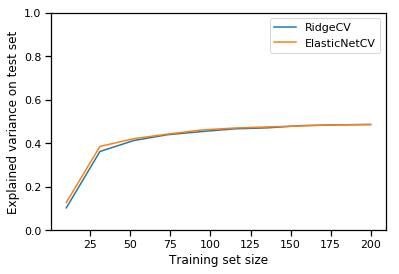

In [39]:
from sklearn.linear_model import ElasticNetCV

plot_learning_curve(RidgeCV())
plot_learning_curve(ElasticNetCV(l1_ratio=.8, n_alphas=10))

## Using Cross-validation for Parameter Tuning

The regularization coefficient can be selected using cross-validation.

In [40]:
lasso = Lasso()

In [41]:
alphas = np.logspace(-4, -1, 20)

scores = np.empty(len(alphas))
scores_std = np.empty(len(alphas))

for i,alpha in enumerate(alphas):
    lasso.alpha = alpha
    s = model_selection.cross_val_score(lasso, diabetes.data, diabetes.target, n_jobs=-1)
    scores[i] = s.mean()
    scores_std[i] = s.std()

Text(0.05,0.489433,'0.489')

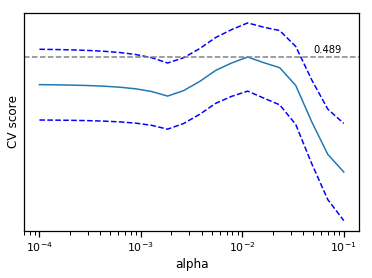

In [42]:
plt.semilogx(alphas, scores)
plt.semilogx(alphas, np.array(scores) + np.array(scores_std)/20, 'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std)/20, 'b--')
plt.yticks(())
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.text(5e-2, np.max(scores)+1e-4, str(np.max(scores).round(3)))

## Exercise: Very low birthweight infants

Compare logistic regression models (using the `linear_model.LogisticRegression` interface) with varying degrees of regularization for the VLBW infant database. Use a relevant scoring function such as the Brier's score as a metric.

$$B = \frac{1}{n} \sum_{i=1}^n (\hat{p}_i - y_i)^2$$

In [43]:
vlbw = pd.read_csv("../data/vlbw.csv", index_col=0)

vlbw = vlbw.replace({'inout':{'born at Duke':0, 'transported':1},
             'delivery':{'abdominal':0, 'vaginal':1},
             'ivh':{'absent':0, 'present':1, 'possible':1, 'definite':1},
             'sex':{'female':0, 'male':1}})

vlbw = vlbw[[u'birth', u'exit', u'hospstay', u'lowph', u'pltct', 
      u'bwt', u'gest', u'meth', 
      u'toc', u'delivery', u'apg1', u'vent', u'pneumo', u'pda', u'cld', 
      u'ivh']].dropna()

In [44]:
# make outcome and data matrix
y = vlbw.pop('ivh').values
X = vlbw

In [45]:
# make brier score function
def brier(mod, X, y):
    phat = mod.fit(X,y).predict_proba(X)
    return np.mean((phat[:,0]-y)**2)

#brier(LogisticRegression(),X,y)

In [46]:
from sklearn.linear_model import LogisticRegression

C = np.logspace(1, 10, 20)

scores_c = np.empty(len(C))
scores_c_std = np.empty(len(C))

for i,c in enumerate(C):
    lr = LogisticRegression(C=c)
    m = cross_val_score(lr,X,y,scoring=brier)
    scores_c[i]=m.mean()
    scores_c_std[i]=m.std()

In [47]:
scores_c

array([0.76963592, 0.77191509, 0.77484024, 0.77618691, 0.77672156,
       0.77605167, 0.775647  , 0.77714533, 0.77518506, 0.77724603,
       0.77850364, 0.77732622, 0.7789257 , 0.77869117, 0.7786453 ,
       0.77669018, 0.77694575, 0.77868022, 0.77773535, 0.77838294])

Text(0.05,0.779026,'0.779')

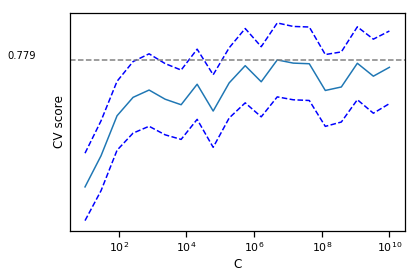

In [48]:
plt.semilogx(C, scores_c)
plt.semilogx(C, np.array(scores_c) + np.array(scores_c_std)/20, 'b--')
plt.semilogx(C, np.array(scores_c) - np.array(scores_c_std)/20, 'b--')
plt.yticks(())
plt.ylabel('CV score')
plt.xlabel('C')
plt.axhline(np.max(scores_c), linestyle='--', color='.5')
plt.text(5e-2, np.max(scores_c)+1e-4, str(np.max(scores_c).round(3)))

## Scores and metrics

In `scikit-learn`, there are 3 different APIs for evaluating the quality of a model’s predictions, which may cause confusion.

We have seen that estimators have a **score method**, which serves as a default evaluation criterion for the problem they are designed to solve.

Model selection and evaluation using tools, such as `GridSearchCV` and `cross_val_score`, take a **scoring parameter** that specifies a metric to apply to the estimators evaluated.

The module `sklearn.metrics` comprises a set of **metrics**, simple functions measuring a prediction error given ground truth and prediction:

- functions ending with `_score` return a value to maximize, the higher the better.
- functions ending with `_error` or `_loss` return a value to minimize, the lower the better. 

Many metrics are not given names to be used as scoring values, sometimes because they require additional parameters. In this case, you need to generate an appropriate scoring object using the `make_scorer` utility function, which converts metrics into callables that can be used for model evaluation.

## Model Checking using Learning Curves

A useful way of checking model performance (in terms of bias and/or variance) is to plot learning curves, which illustrates the learning process as your model is exposed to more data. When the dataset is small, it is easier for a model of a particular complexity to be made to fit the training data well. As the dataset grows, we expect the training error to increase (model accuracy decreases). Conversely, a relatively small dataset will mean that the model will not generalize well, and hence the cross-validation score will be lower, on average.

In [49]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(lasso, 
                                                 diabetes.data, diabetes.target, 
                                                 train_sizes=[50, 70, 90, 110, 130], cv=5)

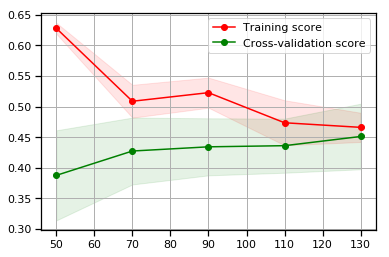

In [50]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")

For models with high bias, training and cross-validation scores will tend to converge at a low value (high error), indicating that adding more data will not improve performance. 

For models with high variance, there may be a gap between the training and cross-validation scores, suggesting that model performance could be improved with additional information.

In [51]:
X,y = salmon.values.T
X2 = PolynomialFeatures(degree=2).fit_transform(X[:, None])

train_sizes, train_scores, test_scores = learning_curve(LinearRegression(), X2, y, 
                                            train_sizes=[10, 15, 20, 30], cv=5)

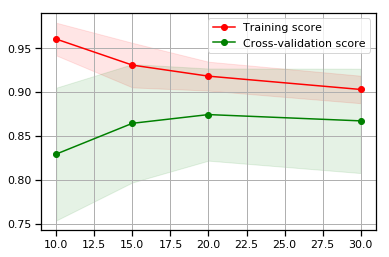

In [52]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")

## Exercise: Pima indians diabetes

Create learning curves for logistic regression models using the Pima Indians diabetese database (Smith et al., 1988) to predict diabetes. Create curves using a range of sample sizes from 25 to 200 for:

1. The complete set of predictor variables
2. The set of polynomial features for the complete set of predictor variables

Interpret the results

In [53]:
pima_diabetes = pd.read_csv('../data/pima-indians-diabetes.data.txt', header=None, 
                            names=['n_pregnant', 'plasma_glucose', 'diastolic_bp', 'skin_thickness', 
                                   'serum_insulin', 'bmi', 'diabetes_pedegree_func', 'age', 'diabetes'])
pima_diabetes.head()

,n_pregnant,plasma_glucose,diastolic_bp,skin_thickness,serum_insulin,bmi,diabetes_pedegree_func,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [54]:
newy = pima_diabetes.pop('diabetes').values
newX = pima_diabetes

In [55]:
train_sizes1, train_scores1, test_scores1 = learning_curve(LogisticRegression(), 
                                                 newX, newy, 
                                                 train_sizes=[25, 50, 75, 100, 125, 150,175, 200], cv=5)

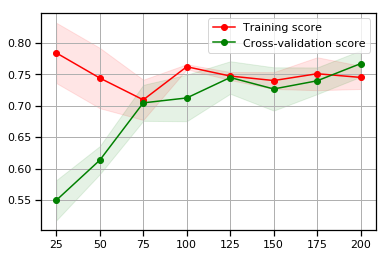

In [56]:
train_scores1_mean = np.mean(train_scores1, axis=1)
train_scores1_std = np.std(train_scores1, axis=1)
test_scores1_mean = np.mean(test_scores1, axis=1)
test_scores1_std = np.std(test_scores1, axis=1)
plt.grid()

plt.fill_between(train_sizes1, train_scores1_mean - train_scores1_std,
                 train_scores1_mean + train_scores1_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes1, test_scores1_mean - test_scores1_std,
                 test_scores1_mean + test_scores1_std, alpha=0.1, color="g")
plt.plot(train_sizes1, train_scores1_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes1, test_scores1_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")

In [57]:
newX2 = PolynomialFeatures(degree=2).fit_transform(newX)

In [58]:
train_sizes2, train_scores2, test_scores2 = learning_curve(LogisticRegression(), 
                                                 newX2, newy, 
                                                 train_sizes=[25, 50, 75, 100, 125, 150,175, 200], cv=5)

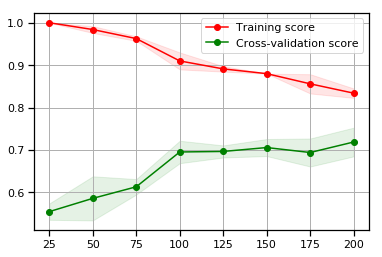

In [59]:
train_scores2_mean = np.mean(train_scores2, axis=1)
train_scores2_std = np.std(train_scores2, axis=1)
test_scores2_mean = np.mean(test_scores2, axis=1)
test_scores2_std = np.std(test_scores2, axis=1)
plt.grid()

plt.fill_between(train_sizes2, train_scores2_mean - train_scores2_std,
                 train_scores2_mean + train_scores2_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes2, test_scores2_mean - test_scores2_std,
                 test_scores2_mean + test_scores2_std, alpha=0.1, color="g")
plt.plot(train_sizes2, train_scores2_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes2, test_scores2_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")

---
## References

- Burnham, K. P., & Anderson, D. R. (2002). [Model Selection and Multi-Model Inference: A Practical, Information-theoretic Approach](http://www.amazon.com/Model-Selection-Multimodel-Inference-Information-Theoretic/dp/0387953647). Springer Verlag.
- Givens, G. H.; Hoeting, J. A. (2012). [Computational Statistics](http://www.stat.colostate.edu/computationalstatistics/) (Wiley Series in Computational Statistics)
- Hastie, T., Tibshirani, R., & Friedman, J. H. (2009). [The elements of statistical learning](http://www-stat.stanford.edu/~tibs/ElemStatLearn/). Springer Verlag.
- Vanderplas, J. [Scikit-learn tutorials for the Scipy 2013 conference](https://github.com/jakevdp/sklearn_scipy2013).